## Introduction to chinook


In this notebook, we work through a calculation of simulated ARPES spectra from scratch. While several input format are accepted in chinook, here we use a Slater-Koster model for a cubic lattice.

In [1]:
#Import the requisite modules for calculation
import numpy as np
import matplotlib.pyplot as plt
import chinook.build_lib as build_lib
import chinook.operator_library as operators
from chinook.ARPES_lib import experiment

We can begin by defining the lattice geometry, which we take here to be a square lattice. Throughout, feel free to try different parameters and geometries

In [2]:
a,c = 5.0,5.0
avec = np.array([[np.sqrt(0.5)*a,np.sqrt(0.5)*a,0],[np.sqrt(0.5)*a,-np.sqrt(0.5)*a,0],[0,0,c]])

In chinook, functions which require many input arguments take dictionary-input, taking advantage of the readibility and tidyness of this datatype. Specifically, orbital basis, Hamiltonian, ARPES configurations are all defined using dictionaries. The first relevant object will be the momentum path, used for defining a high-symmetry path to first explore our tight-binding model.

In [3]:
kpoints = np.array([[0.5,0.5,0.0],[0.0,0.0,0.0],[0.5,-0.5,0.0]])
labels = np.array(['$M_x$','$\Gamma$','$M_y$'])



kdict = {'type':'F',
        'avec':avec,
        'pts':kpoints,
        'grain':200,
        'labels':labels}

k_object = build_lib.gen_K(kdict)
print('High-Symmetry Points:')
print(np.around(k_object.pts,3))

High-Symmetry Points:
[[0.889 0.    0.   ]
 [0.    0.    0.   ]
 [0.    0.889 0.   ]]


Above, we get the first example of a dictionary-based set of arguments. We defined a k-path in fractional coordinate ('type':'F'). This requires the lattice vectors ('avec':avec) to define the path in units of inverse angstrom. The path itself is defined by 'points'. The 'grain' argument allows us to vary the number of steps between each segment of the k-path. Finally, we can pass an optional array of 'labels', for improving the readibility of figures plotted. 

We can now proceed to define our orbital basis. Since here I will use Antimony 5p states, we should include spin-orbit coupling, which is done with its own dictionary arguments. I define this on its own here, as I will want to re-use this dictionary for generating the Hamiltonian with spin-orbit coupling.

In [4]:
spin = {'bool':True,  #include spin-degree of freedom: double the orbital basis
       'soc':True,    #include atomic spin-orbit coupling in the calculation of the Hamiltonian
       'lam':{0:0.5}} #spin-orbit coupling strength in eV, require a value for each unique species in our basis

Sb1 = np.array([0.0,0.0,0.0])
Sb2 = np.array([np.sqrt(0.5)*a,0,0])

basis = {'atoms':[0,0], #two equivalent atoms in the basis, both labelled as species #0
        'Z':{0:51},     #We only have one atomic species, which is antimony #51 in the periodic table.
        'orbs':[['51x','51y','51z'],['51x','51y','51z']], #each atom includes a full 5p basis in this model, written in n-l-xx format
        'pos':[Sb1,Sb2], #positions of the atoms, in units of Angstrom
        'spin':spin} #spin arguments.


basis_object = build_lib.gen_basis(basis)

We have defined the location of each atom in the orbital basis, and its full orbital content. Here we work with a full antimony 5p basis on each site. I have taken the second basis atom to sit in the centre of the ab plane, but you are free to modify this, as well as spin-orbit coupling strength, or even the atomic character

At this point, we can define the Hamiltonian for our model. We will use a Slater Koster model for this, and we will assume nearest neighbour hoppings only. The options for the type of Hamiltonian are much more extensive, but the Slater Koster framework is very amenable to tuning parameters, so is a nice option for this tutorial. For p-p hopping, Slater Koster requires only 3 parameters: the on-site energy $\epsilon_p$, $V_{pp\sigma}$ and $V_{pp\pi}$.

In [5]:
Ep = 0.7
Vpps = 0.25
Vppp = -1.0
VSK = {'051':Ep,'005511S':Vpps,'005511P':Vppp}
cutoff = 0.72*a

######################################################################
#####Option: nearest neighbour, and next nearest neighbour hopping  ##
V1 = {'051':Ep,'005511S':Vpps,'005511P':Vppp}                     ##
V2 = {'005511S':Vpps/a,'005511P':Vppp/a}                          ##
VSK = [V1,V2]                                                     ##
cutoff = [0.8*a,1.1*a]                                            ##
######################################################################

hamiltonian = {'type':'SK',     #Slater-Koster type Hamiltonian
              'V':VSK,          #dictionary (or list of dictionaries) of onsite and hopping potentials
               'avec':avec,     #lattice geometry
              'cutoff':cutoff,  #cutoff length-scale for hopping
              'renorm':1.0,     #renormalize bandwidth of Hamiltonian 
               'offset':0.0,    #offset the Fermi level
              'tol':1e-4,       #minimum amplitude for matrix element to be included in model.
              'spin':spin}      #spin arguments, as defined above

Finally, we can bring all this together to define a tight-binding model object.

In [6]:
TB = build_lib.gen_TB(basis_object,hamiltonian,k_object)

With the model so defined, we can now diagonalize, and perform some diagnostics on the tight-binding model. We start by plotting the bandstructure over the k path.

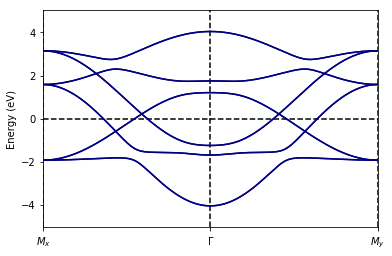

In [7]:
TB.Kobj = k_object
TB.solve_H()
TB.plotting()

In the above model, we see the full bandstructure along high-symmetry directions for this model. Notably, the $k_z$ dispersion is zero, as the c-lattice constant is larger than our cutoff-lengthscale. You can try adjusting the cutoff distance, or the c-lattice constant to introduce these hopping terms.

There are several ways in which we can characterize our tight-binding model before proceeding to calculation of the photoemission intensity. Here, we consider the orbital projection or 'fat bands' plot, which illustrates the orbital weight of different different basis states. Before doing this, it's instructive to refer to the orbital basis ordering in our model. 

In [8]:
TB.print_basis_summary()

 Index | Atom | Label | Spin |     Position     
    0  |   0  |51x    |  -0.5| 0.000,0.000,0.000
    1  |   0  |51y    |  -0.5| 0.000,0.000,0.000
    2  |   0  |51z    |  -0.5| 0.000,0.000,0.000
    3  |   0  |51x    |  -0.5| 3.536,0.000,0.000
    4  |   0  |51y    |  -0.5| 3.536,0.000,0.000
    5  |   0  |51z    |  -0.5| 3.536,0.000,0.000
    6  |   0  |51x    |   0.5| 0.000,0.000,0.000
    7  |   0  |51y    |   0.5| 0.000,0.000,0.000
    8  |   0  |51z    |   0.5| 0.000,0.000,0.000
    9  |   0  |51x    |   0.5| 3.536,0.000,0.000
   10  |   0  |51y    |   0.5| 3.536,0.000,0.000
   11  |   0  |51z    |   0.5| 3.536,0.000,0.000


We want to plot the projection onto all $p_x$, $p_y$, and $p_z$ orbitals. We see that orbitals the set {0,3,6,9} are all $p_x$, {1,4,7,10} are $p_y$ and {2,5,8,11} are $p_z$. To visualize these projections then:

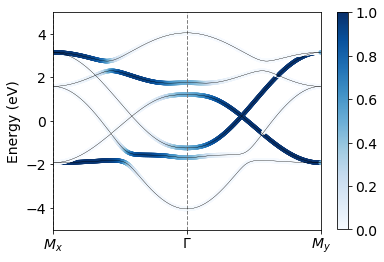

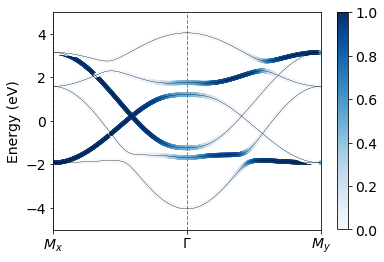

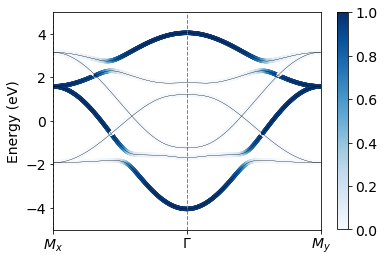

In [9]:
px = operators.fatbs(proj=[0,3,6,9],TB=TB,Elims=(-5,5),degen=True)
py = operators.fatbs(proj=[1,4,7,10],TB=TB,Elims=(-5,5),degen=True)
pz = operators.fatbs(proj=[2,5,8,11],TB=TB,Elims=(-5,5),degen=True)
#The degen flag averages over degenerate states. All states are at least two-fold degenerate,
#so this flag should certainly be on here.

From this, we see that the bandwidth of the $p_z$ band is largest, over 2 eV larger than that of the in-plane $p_{x,y}$ states. Furthermore, plotting along the $k_x$ and $k_y$ directions, we see clearly the strong momentum dependence of the orbital character, which relaxes only near the avoided crossings where SOC mixes the orbital character.

In addition to orbital projections, we can also compute the expectation value of any Hermitian operator, and plot is value over each of the bands in a similar way. In this model, we have included spin-orbit coupling, and so we can plot $\left< \vec{L}\cdot\vec{S}\right>$ as an example.

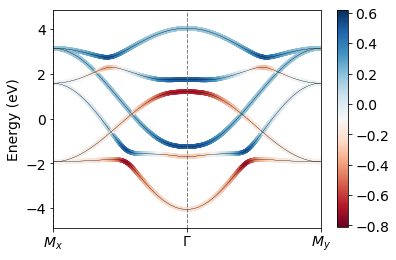

In [10]:
LdS_matrix = operators.LSmat(TB)
LdS = operators.O_path(LdS_matrix,TB,degen=True)


While here I have made use of the built-in function operators.LSmat to generate my operator matrix, one can pass in principal any valid Hermitian operator defined over the dimension of the orbital basis: in this case we require a 12 $\times$ 12 Hermitian matrix.

While a number of other tools are available for model diagnostics, we'll proceed now to consideration of ARPES intensity simulation. Similar to the inputs defined above, we make use of Python dictionaries to organize the input 
arguments. Above, we saw that the Brillouin zone extends over a square of side-length 1.256 Å$^{-1}$. We will begin by looking at the Fermi surface of our material.

In [11]:
arpes = {'cube':{'X':[-0.628,0.628,300],'Y':[-0.628,0.628,300],'E':[-0.05,0.05,50],'kz':0.0}, #domain of interest
        'hv':100,                          #photon energy, in eV
         'T':10,                           #temperature, in K
        'pol':np.array([1,0,-1]),           #polarization vector
        'SE':['constant',0.02],            #self-energy, assume for now to be a constant 20 meV for simplicity
        'resolution':{'E':0.02,'k':0.02}}  #resolution

In [12]:
arpes_experiment = experiment(TB,arpes)
arpes_experiment.datacube()

Initiate diagonalization: 
Large memory load: splitting diagonalization into 51 segments
Diagonalization Complete.
Begin computing matrix elements: 
||||||||||||||||||||||||||||||100%
Done matrix elements


True

Once the matrix elements have been calculated, the spectrum can be plot

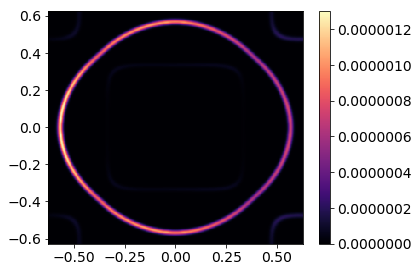

In [13]:
_ = arpes_experiment.spectral(arpes,slice_select=('w',-0.0))

In consideration of the bandstructure above, we expect 3 Fermi-surface sheets, so why do we only see two? This is an explicit consequence of the matrix-element effects. If we consider the orbital-projected plots above, the large spin-orbit coupling strongly mixes the orbital character over much of the Fermi-surface. However, $p_z$ character, which we are most strongly sensitive to with this polarization, is vanishing on the inner-most Fermi surface sheet. This readily explains its absence here. By however rotating polarization to be strictly in-plane, we can recover this sheet.

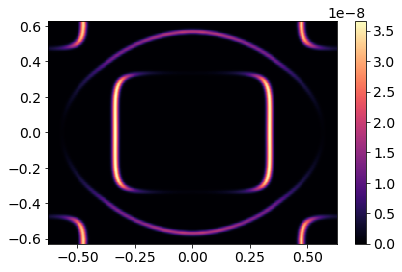

In [14]:
arpes['pol'] = np.array([0,1,0])
_ = arpes_experiment.spectral(arpes,slice_select=('w',0))


We can explore the evolution of the orbital character and ARPES intensity over a broader range of momentum by computing the matrix elements over a wider energy window. Below, we do so for a fixed in-plane momentum

Initiate diagonalization: 
Diagonalization Complete.
Begin computing matrix elements: 
||||||||||||||||||||||||||||||100%
Done matrix elements


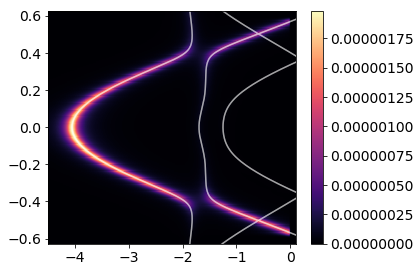

In [15]:
arpes['cube'] = {'X':[-0.628,0.628,200],'Y':[0,0,1],'kz':0,'E':[-4.5,0.1,1000]}
arpes['SE'] = ['constant',0.1]
arpes['pol'] = np.array([1,0,-1])
arpes_experiment = experiment(TB,arpes)
arpes_experiment.datacube()
_ = arpes_experiment.spectral(slice_select=('y',0),plot_bands=True)

Another perspective on the connection to orbital character can be gained by again, changing the polarization:

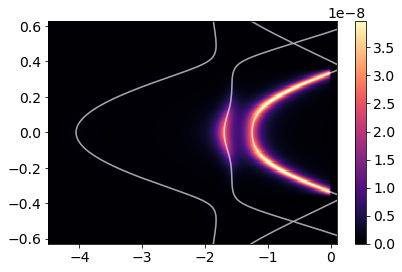

In [16]:
arpes['pol'] = np.array([0,1,0])
_ = arpes_experiment.spectral(arpes,slice_select=('y',0),plot_bands=True)


While some bands are suppressed as a result of orbital and polarization symmetry, others still are suppressed due photoelectron interference. Our choice of a two-site unit cell is somewhat artificial, as there is no translational-symmetry breaking potential which prevents us from using a smaller one-atom unit cell. The folded bands in the reduced Brillouin zone of our excessively large unit cell can be described as anti-bonding states. To demonstrate this, we can perform a similar calculation over a wider domain of momentum, covering a full cut through the full Brillouin zone of the one-atom unit cell:

Initiate diagonalization: 
Diagonalization Complete.
Begin computing matrix elements: 
||||||||||||||||||||||||||||||100%
Done matrix elements


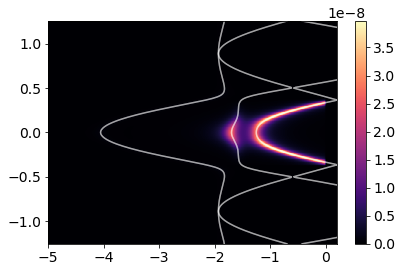

In [17]:
arpes['cube'] = {'X':[-1.256,1.256,300],'Y':[0,0,1],'kz':0,'E':[-5,0.2,1000]}
arpes_experiment = experiment(TB,arpes)
arpes_experiment.datacube()
_ = arpes_experiment.spectral(slice_select=('y',0),plot_bands=True)


In this tutorial, we have seen how to define and characterize a tight-binding model using chinook. In addition to this, we have performed a few calculations of the photoemission intensity associated with this model, and seen a few ways in which the photoemission intensity is affected by the nature of both our system of interest and the experimental geometry. Feel free to make changes to the model here and experiment with different parameters to get a better sense of how to use some of these tools. You're now ready to begin building your own models and simulating ARPES intensity for your material of choice. For further information, visit https://chinookpy.readthedocs.io for the full chinook documentation and more information.